## PCA definition and analysis

#### Data loading and generation of artificial relabeling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

data = pd.read_pickle("ultradata.pkl")

In [2]:
from sklearn.model_selection import train_test_split
data["LabelGen"] = data["Label"].map(lambda x: "MALIGNANT" if x!="BENIGN" else "BENIGN")
data = data.loc[data["Day"]=="Wednesday"]
#https://stackoverflow.com/questions/57507832/unable-to-allocate-array-with-shape-and-data-type
# data["Destination Port"] = data["Destination Port"].astype("int16")
# data = pd.get_dummies(data,prefix="Port",prefix_sep="-",columns=["Destination Port"])

# indices = np.random.choice(list(range(data.shape[0])),100000)
# data = data.iloc[indices]
# data,test = train_test_split()

In [3]:
data.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,Day,LabelGen
0,80,38308,1,1,6,6,6,6,6.000000,0.000000,...,0.0,0,0,0.0,0.0,0,0,BENIGN,Wednesday,BENIGN
1,389,479,11,5,172,326,79,0,15.636364,31.449238,...,0.0,0,0,0.0,0.0,0,0,BENIGN,Wednesday,BENIGN
2,88,1095,10,6,3150,3150,1575,0,315.000000,632.561635,...,0.0,0,0,0.0,0.0,0,0,BENIGN,Wednesday,BENIGN
3,389,15206,17,12,3452,6660,1313,0,203.058823,425.778474,...,0.0,0,0,0.0,0.0,0,0,BENIGN,Wednesday,BENIGN
4,88,1092,9,6,3150,3152,1575,0,350.000000,694.509719,...,0.0,0,0,0.0,0.0,0,0,BENIGN,Wednesday,BENIGN


In [4]:
pd.value_counts(data["Label"])

BENIGN              440031
DoS Hulk            231073
DoS GoldenEye        10293
DoS slowloris         5796
DoS Slowhttptest      5499
Heartbleed              11
Name: Label, dtype: int64

In [5]:
# nulos = data[data.isnull().any(axis=1)]
# infs = data.loc[data.isin([np.inf,-np.inf]).any(axis=1)]

https://www.cienciadedatos.net/documentos/py19-pca-python.html  
https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60

## 1. PCA

#### 1.1. Data preprocessing

In [5]:
from sklearn.preprocessing import StandardScaler
pca_data = data.drop(columns=["Day","Destination Port"])
# pca_data = data.drop(columns=["Day"])
# pca_data = data.iloc[:,list(range(1,78))+[-3, -1]].copy()
pca_data_nonan = pca_data.dropna()
pca_data_tot= pca_data_nonan.loc[~pca_data_nonan.isin([np.inf,-np.inf]).any(axis=1)]
pca_data_tot = pca_data_tot.reset_index().drop(columns=["index"])
pca_data_no = pca_data_tot.drop(columns=["Label","LabelGen"])
# pca_data_nonan = pca_data[~pca_data.isnull().any(axis=1)]
pca_data_scaled = StandardScaler().fit_transform(pca_data_no)

#### 1.2. Function definition

The best option is to create a class with all of these functions but I don't have time...

http://www.sthda.com/english/articles/31-principal-component-methods-in-r-practical-guide/112-pca-principal-component-analysis-essentials/#:~:text=The%20contribution%20of%20a%20variable,total%20cos2%20of%20the%20component).

In [6]:
import seaborn as sns
def plot_elbow(explained_variances,num_variables,firstN="all"):
#     explained_variances = list(explained_variances)
#     xp_round = [round(x,3) for x in explained_variances]
    if firstN != "all":
        explained_variances = explained_variances[:firstN]
    plt.bar(x=list(range(1,len(explained_variances)+1)),height=explained_variances)
    plt.xlabel("Principal Component")
    plt.ylabel("Explained variance ratio")
#     plt.bar(x=list(range(1,len(explained_variances)+1)),height=explained_variances,tick_label=xp_round)
    expected_var = 1/num_variables
    print(f"Selected comps: {len(np.where(explained_variances>expected_var)[0])}")
    plt.hlines(y=expected_var,xmin=1,xmax=len(eigenvalues)+1,colors="red",linestyles="dashed")
    plt.title("Explained variance for each PC")
    plt.show()
    
def plot_eigenvalues(eigenvalues,firstN="all"):
    eigenvalues = list(eigenvalues)
    if firstN != "all":
        eigenvalues = eigenvalues[:firstN]
    plt.bar(x=list(range(1,len(eigenvalues)+1)),height=eigenvalues)
    plt.xlabel("Principal Component")
    plt.ylabel("Eigenvalue (explained variance)")
    plt.hlines(y=1,xmin=1,xmax=len(eigenvalues)+1,colors="red",linestyles="dashed")
    plt.title("Explained variance for each PC")
    plt.show()
    
def get_last_best_eigenvalue(eigenvalues):
    pos = np.where(eigenvalues>1)[0]
    subset = eigenvalues[pos]
    print(f"First {len(pos)} components")
    return subset

def plot_scores(scores,pc1=1,pc2=2, score_color = None, annotate=[]):
    if score_color is not None:
        sns.scatterplot(scores[:,pc1-1],scores[:,pc2-1],hue=score_color)
#         plt.scatter(scores[:,pc1-1],scores[:,pc2-1],c=score_color)
    else:
        plt.scatter(scores[:,pc1-1],scores[:,pc2-1])
    for index in annotate:
        plt.annotate(text=index,xy=(scores[index,pc1-1],scores[index,pc2-1]))
    plt.xlabel(f"PC {pc1}")
    plt.ylabel(f"PC {pc2}")
    plt.title("Score plot")
    plt.grid()

    
def plot_loadings(loadings,variables,pc1 = 1, pc2 = 2, drawLabels=False, col = "contrib"):
    n = loadings.shape[1]
    if col is None:
        plt.scatter(loadings[pc1-1,:],loadings[pc2-1,:])
    elif col == "cos2" or col=="contrib":
        cos2 = loadings**2
        cos2_sums = np.sum(cos2[[pc1-1,pc2-1],:],axis=0)
        if col == "cos2":
            plt.scatter(loadings[pc1-1,:],loadings[pc2-1,:],c=cos2_sums)
        else:
            contrib = (cos2.T / np.sum(cos2,axis=1)).T
            contrib_sum = np.sum(contrib[[pc1-1,pc2-1],:],axis=0)
            plt.scatter(loadings[pc1-1,:],loadings[pc2-1,:],c=contrib_sum)
        plt.colorbar()
        plt.clim(0,1)
        
    
    for i in range(n):
        v1,v2 = loadings[pc1-1,i],loadings[pc2-1,i]
#         plt.arrow(0, 0, v1, v2,color = 'r',alpha = 0.5)
        if drawLabels:
            plt.text(v1* 1.15, v2 * 1.15, variables[i], color = 'g', ha = 'center', va = 'center')
    plt.xlabel(f"PC {pc1}")
    plt.ylabel(f"PC {pc2}")
    plt.grid()   
    
"""def plot_loadings(loadings,pc1 = 1, pc2 = 2, drawLabels=False):
    n = loadings.shape[0]
    pcs = loadings.columns[[pc1-1,pc2-1]]
    variables = loadings.index
    loadings = loadings.iloc[:,[pc1-1,pc2-1]]
    for i in range(n):
        v1,v2 = loadings.iloc[i,0],loadings.iloc[i,1]
        plt.arrow(0, 0, v1, v2,color = 'r',alpha = 0.5)
        if drawLabels:
            plt.text(v1* 1.15, v2 * 1.15, variables[i], color = 'g', ha = 'center', va = 'center')
    plt.xlabel(pcs[0])
    plt.ylabel(pcs[1])
    plt.grid()"""
    
def SCE(scores, selected_components): #variability of each observation explained by each PC
    return np.sum(scores**2,axis=1)

def T2_Hottelling(scores,eigenvalues,selected_components,plot=True):
    t2 = np.sum(scores[:,list(range(3))]**2 / eigenvalues[:3],axis=1)
    ndata = scores.shape[0]
    frac = selected_components*(ndata**2-1)/(ndata*(ndata-selected_components))
    f95 = frac * stats.f.ppf(0.95,selected_components,ndata-selected_components)
    f99 = frac * stats.f.ppf(0.99,selected_components,ndata-selected_components)
    if plot:
        plt.plot(t2)
        plt.hlines(y=f95,xmin=0,xmax=ndata,colors="orange",linestyles="dashed")
        plt.hlines(y=f99,xmin=0,xmax=ndata,colors="red",linestyles="dashed")
    return t2,f95,f99

def SPE(original_data, scores, loadings, selected_components,plot=True):
    ndata = scores.shape[0]
    scores = scores[:,:selected_components]
    loadings = loadings[:selected_components,:]
    reconstructed_data = np.matmul(scores,loadings)
    residuals = original_data-reconstructed_data
    scr_i = np.sum(residuals**2,axis=1)
    g = np.var(scr_i)/(2*np.mean(scr_i))
    h = 2*np.mean(scr_i)**2/np.var(scr_i)
    chi2_95 = g*stats.chi2.ppf(0.95,df=h)
    chi2_99 = g*stats.chi2.ppf(0.99,df=h)
    if plot:
        plt.plot(scr_i)
        plt.hlines(y=chi2_95,xmin=0,xmax=ndata,colors="orange",linestyles="dashed")
        plt.hlines(y=chi2_99,xmin=0,xmax=ndata,colors="red",linestyles="dashed")
    return scr_i,chi2_95,chi2_99

def SPE2(original_data, scores, loadings, selected_components,eigenvalues,plot=True):
    ndata = scores.shape[0]
    scores = scores[:,:selected_components]
    loadings = loadings[:selected_components,:]
    reconstructed_data = np.matmul(scores,loadings)
    residuals = original_data-reconstructed_data
    scr_i = np.sum(residuals**2,axis=1)
    theta1 = np.sum(eigenvalues[selected_components:])
    theta2 = np.sum(eigenvalues[selected_components:]**2)
    theta3 = np.sum(eigenvalues[selected_components:]**3)
    h0 = 1 - 2*theta1*theta3 / (3*theta2)
    z095 = stats.norm.ppf(0.95)
    z099 = stats.norm.ppf(0.99)
    q095 = theta1 * ((z095*(2*theta2*(h0**2))**0.5)/theta1 + (theta2*h0*(h0-1))/(theta1**2) + 1)**(1/h0)
    q099 = theta1 * ((z099*(2*theta2*(h0**2))**0.5)/theta1 + (theta2*h0*(h0-1))/(theta1**2) + 1)**(1/h0)
    #https://www.cheric.org/files/education/cyberlecture/d201401/d201401-1001.pdf
    if plot:
        plt.plot(scr_i)
        plt.hlines(y=q095,xmin=0,xmax=ndata,colors="orange",linestyles="dashed")
        plt.hlines(y=q099,xmin=0,xmax=ndata,colors="red",linestyles="dashed")
    return scr_i,q095,q099

def get_outlier_indexes(tsp_scores,limit):
    pos = np.where(tsp_scores>limit)[0]
    print(f"Number of data points that exceed limit: {len(pos)}")
    return pos

def plot_contribs(data,loadings,indivs,pc,SIMCA=True):
    subset = data.iloc[indivs]
    cols = data.columns
    data = np.array(data)
    subset = np.array(subset)
    means = np.mean(data,axis=0)
    contribs = []
    for i in range(len(cols)):
        if SIMCA:
            cont = (subset[:,i]-means[i])*np.abs(loadings[pc-1,i])
        else:
            cont = (subset[:,i]*loadings[pc,i])
        contribs.append(cont)
    contribs = np.array(contribs).T
    cc = np.mean(contribs,axis=0)
    plt.bar(x=cols,height=cc)
    return contribs

#### 1.3. PCA V1. All components to see which ones are better

In [7]:
from sklearn.decomposition import PCA
pca = PCA()
scores = pca.fit_transform(pca_data_scaled)
loadings = pca.components_
eigenvalues = pca.explained_variance_
explained_variances = pca.explained_variance_ratio_
c = [f"PC{i}" for i in range(1,pca.n_components_+1)]
pcdata = pd.DataFrame(scores,columns=c)

Selected comps: 17


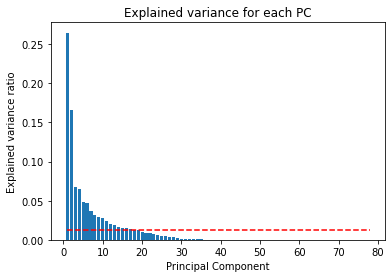

In [8]:
plot_elbow(pca.explained_variance_ratio_,num_variables=pca_data_scaled.shape[1])

First 15 components


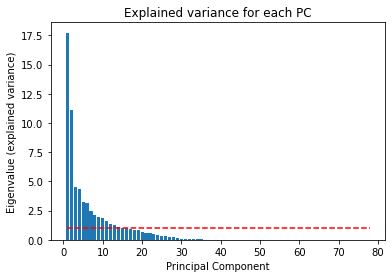

In [9]:
get_last_best_eigenvalue(pca.explained_variance_)
plot_eigenvalues(pca.explained_variance_)

PCA with only 15 components

In [10]:
"""pca = PCA(19)
scores = pca.fit_transform(pca_data_scaled)
loadings = pca.components_
eigenvalues = pca.explained_variance_
explained_variances = pca.explained_variance_ratio_
c = [f"PC{i}" for i in range(1,pca.n_components_+1)]
pcdata = pd.DataFrame(scores,columns=c)"""

'pca = PCA(19)\nscores = pca.fit_transform(pca_data_scaled)\nloadings = pca.components_\neigenvalues = pca.explained_variance_\nexplained_variances = pca.explained_variance_ratio_\nc = [f"PC{i}" for i in range(1,pca.n_components_+1)]\npcdata = pd.DataFrame(scores,columns=c)'

C:\Users\Gonzalo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Gonzalo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Gonzalo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Gonzalo

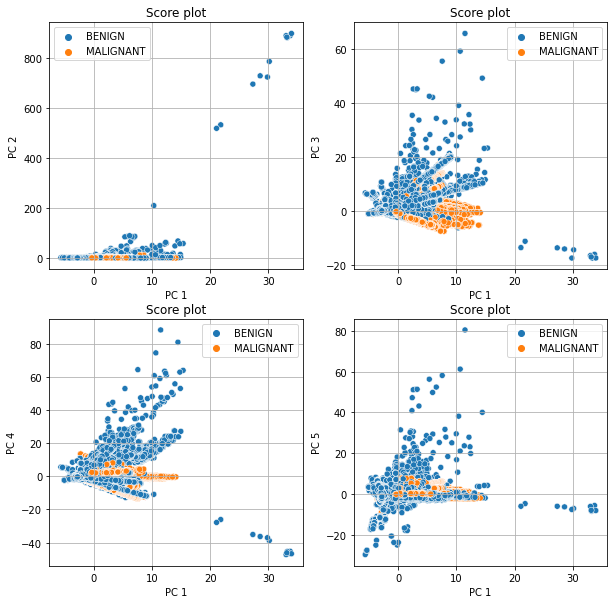

In [10]:
# plot_scores(scores)
plt.figure(figsize=(10,10))
for i in range(2,6):
    plt.subplot(2,2,i-1)
    plot_scores(scores,score_color=list(pca_data_tot["LabelGen"]),pc1=1,pc2=i)

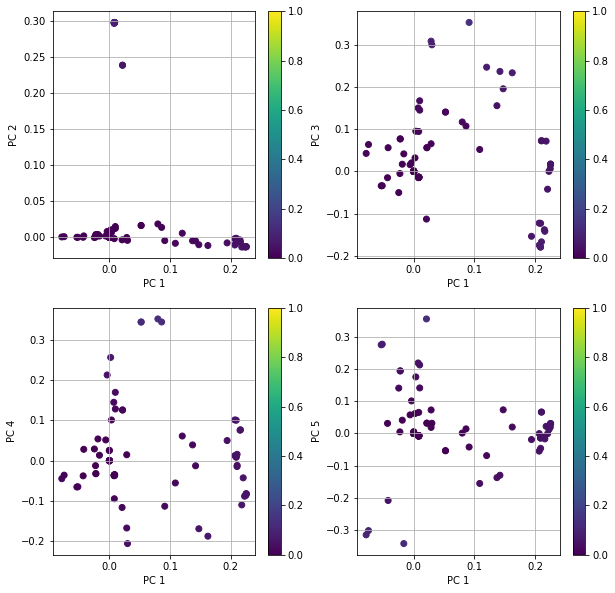

In [11]:
# plot_loadings(loadings,pca_data.columns,col="contrib",pc1=1,pc2=2,drawLabels=True)
plt.figure(figsize=(10,10))
for i in range(2,6):
    plt.subplot(2,2,i-1)
    plot_loadings(loadings,pca_data.columns,col="contrib",pc1=1,pc2=i,drawLabels=False)

In [12]:
columns = pca_data_no.columns
pc2_correlated = np.where(loadings[1,:]>0.1)

In [13]:
columns[pc2_correlated]

Index(['Total Fwd Packets', 'Total Backward Packets',
       'Total Length of Fwd Packets', 'Total Length of Bwd Packets',
       'Fwd Header Length', 'Bwd Header Length', 'Fwd Header Length.1',
       'Subflow Fwd Packets', 'Subflow Fwd Bytes', 'Subflow Bwd Packets',
       'Subflow Bwd Bytes', 'act_data_pkt_fwd'],
      dtype='object')

In [14]:
pc1_correlated_right = np.where(loadings[0,:]>0.1)
columns[pc1_correlated_right]

Index(['Flow Duration', 'Bwd Packet Length Max', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow IAT Mean', 'Flow IAT Std',
       'Flow IAT Max', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std',
       'Fwd IAT Max', 'Bwd IAT Total', 'Bwd IAT Std', 'Bwd IAT Max',
       'Max Packet Length', 'Packet Length Mean', 'Packet Length Std',
       'Packet Length Variance', 'FIN Flag Count', 'Average Packet Size',
       'Avg Bwd Segment Size', 'Idle Mean', 'Idle Max', 'Idle Min'],
      dtype='object')

In [15]:
pc1_correlated_left = np.where((loadings[0,:]<0.1)&(loadings[1,:]<0.1))
columns[pc1_correlated_left]

Index(['Fwd Packet Length Max', 'Fwd Packet Length Min',
       'Fwd Packet Length Mean', 'Fwd Packet Length Std',
       'Bwd Packet Length Min', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Min', 'Fwd IAT Min', 'Bwd IAT Mean', 'Bwd IAT Min',
       'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags',
       'Fwd Packets/s', 'Bwd Packets/s', 'Min Packet Length', 'SYN Flag Count',
       'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count',
       'CWE Flag Count', 'ECE Flag Count', 'Down/Up Ratio',
       'Avg Fwd Segment Size', 'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk',
       'Fwd Avg Bulk Rate', 'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk',
       'Bwd Avg Bulk Rate', 'Init_Win_bytes_forward',
       'Init_Win_bytes_backward', 'min_seg_size_forward', 'Active Mean',
       'Active Std', 'Active Max', 'Active Min', 'Idle Std'],
      dtype='object')

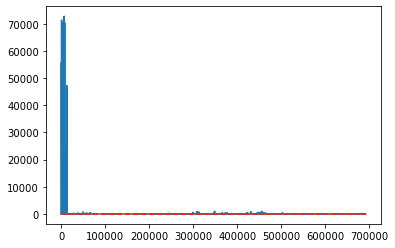

In [16]:
t2,f95,f99 = T2_Hottelling(scores,eigenvalues,15)
# eigenvalues[:3]

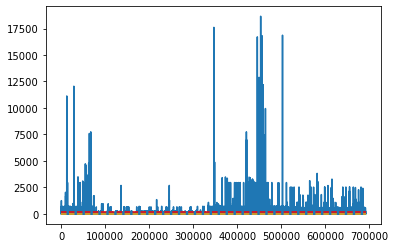

In [17]:
spe,c95,c99 = SPE(pca_data_scaled, scores, loadings, selected_components=15,plot=True)

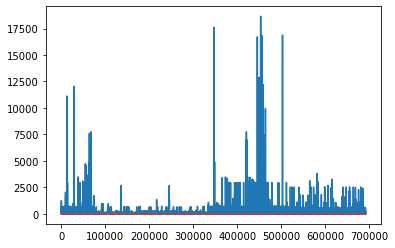

In [18]:
spe,q95,q99 = SPE2(pca_data_scaled, scores, loadings, selected_components=15,eigenvalues=eigenvalues,plot=True)

In [19]:
get_outlier_indexes(spe,c99)

Number of data points that exceed limit: 1784


array([    20,     60,     61, ..., 690870, 690928, 691068], dtype=int64)

In [20]:
get_outlier_indexes(spe,q99)

Number of data points that exceed limit: 198554


array([     0,      7,      8, ..., 691393, 691394, 691400], dtype=int64)

Number of data points that exceed limit: 3957
Number of data points that exceed limit: 3957
Number of data points that exceed limit: 3957
Number of data points that exceed limit: 3957


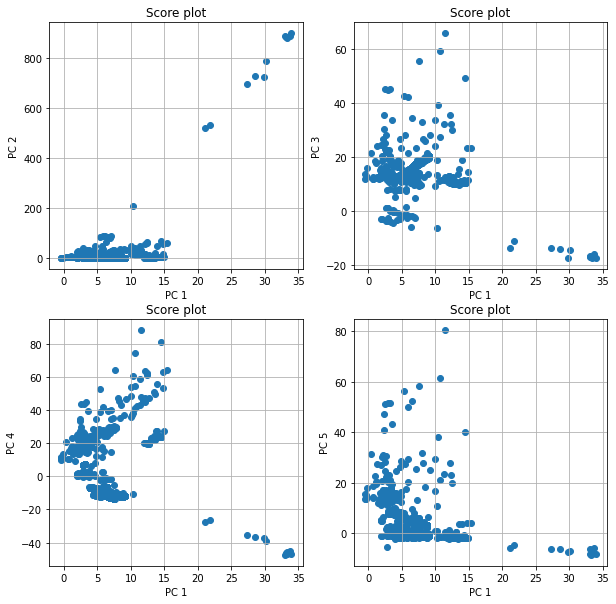

In [22]:
plt.figure(figsize=(10,10))
for i in range(2,6):
    plt.subplot(2,2,i-1)
    plot_scores(scores[get_outlier_indexes(t2,f99)],pc1=1,pc2=i)

In [34]:
np.where(t2>f99)

(array([    20,     61,     63, ..., 684946, 686818, 690346], dtype=int64),)

In [27]:
derecha = np.where(scores[get_outlier_indexes(t2,f99)][:,0]>30)[0]

Number of data points that exceed limit: 3391


In [28]:
pca_data_tot.iloc[derecha]

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,LabelGen
5,433,11,4,172,326,79,0,15.636364,31.449238,163,...,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN,BENIGN
9,4,3,0,18,0,6,6,6.000000,0.000000,0,...,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN,BENIGN
36,1108,9,6,3130,3124,1565,0,347.777778,690.100134,1562,...,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN,BENIGN
38,297216,9,8,1489,5819,581,0,165.444444,228.003350,1460,...,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN,BENIGN
40,4,3,0,0,0,0,0,0.000000,0.000000,0,...,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN,BENIGN
42,194415,20,24,176,426,43,0,8.800000,12.680694,52,...,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN,BENIGN
49,235912,13,15,5785,16832,3441,0,445.000000,986.207128,2920,...,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN,BENIGN


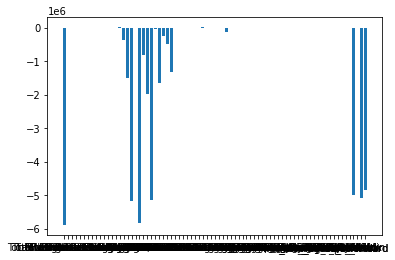

In [29]:
cc = plot_contribs(pca_data_no,loadings,derecha,pc=1)

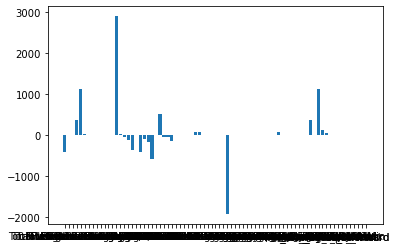

In [30]:
cc = plot_contribs(pca_data_no,loadings,derecha,SIMCA=False,pc=1)

In [31]:
#extreme values considering Hottelling's T2 
pca_data_tot.iloc[np.where(t2>f99)[0]]

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,LabelGen
20,8356382,62,92,182818,36159,23360,0,2948.677419,4935.978657,2920,...,2573038.0,0.0,2573038,2573038,5549208.0,0.0,5549208,5549208,BENIGN,BENIGN
63,3803148,40,58,139678,9909,23360,0,3491.950000,4252.748282,2920,...,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN,BENIGN
77,4866509,37,55,138078,6506,24820,0,3731.837838,4323.523059,1460,...,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN,BENIGN
235,20068893,67,99,212726,36311,23360,0,3175.014925,5311.573186,3989,...,5536745.0,0.0,5536745,5536745,14200000.0,0.0,14200000,14200000,BENIGN,BENIGN
253,5287852,32,59,146407,6654,23360,0,4575.218750,5577.708489,1477,...,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
681319,90592430,9,2,1161,8,165,0,129.000000,71.451032,6,...,6263709.0,0.0,6263709,6263709,21100000.0,13400000.0,36500000,6832001,BENIGN,BENIGN
682197,63104148,9951,14759,81743,29400000,1460,0,8.214551,35.345674,10220,...,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN,BENIGN
684946,90875349,170,302,263752,305178,6046,6,1551.482353,2211.086100,4402,...,26400000.0,0.0,26400000,26400000,5537733.0,0.0,5537733,5537733,BENIGN,BENIGN
686818,98497343,2,2,105,184,56,49,52.500000,4.949747,112,...,571.0,0.0,571,571,98300000.0,0.0,98300000,98300000,BENIGN,BENIGN


In [33]:
# pd.value_counts(pca_data_tot.iloc[np.where(t2>f99)[0]]["Destination Port"])

### ML Task

https://learnche.org/pid/latent-variable-modelling/principal-component-analysis/interpreting-the-residuals

https://stats.stackexchange.com/questions/55718/pca-and-the-train-test-split

https://www.speedguide.net/ports.php?filter=&sort=&p=0

In [ ]:
https://stackoverflow.com/questions/20864847/probability-to-z-score-and-vice-versa